# AI Project 1: Bank Fraud Detection

### Following you will need to solve a Bank Fraud Detection Case where you will classify two multiple-feature groups.

**Data Description:**

**test.csv** - the test set, contains customer’s basic attributes and payment histories. You must predict whether these customers are credible or not.

**sample submission.csv** - a file showing the correct submission format. You must replace the NA’s with the predicted class labels. You should show your results by submitting the .csv file according to the format of this sampleSubmission.csv.

**id**: A unique Id field which represents a customer

**X1**: Credit line

**X2**: Gender (1 = male; 2 = female).

**X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

**X4**: Marital status (1 = married; 2 = single; 3 = others).

**X5**: Age (year).

**X6 - X11**: History of past payment. X6 = September, 2015;

**X7** = August, 2015;

**X11** =April, 2015. -1 = pay one month ahead; -2 = pay two month ahead; 0 = pay on time; Positive means the payment delayed months, 1 = delay 1 month, 2 = delay 2 months, etc.

**X12 - X17**: Amount in bill statement.

**X12** = amount of bill statement September, 2015

**X13** = amount of bill statement August, 2015

**X17** = amount of bill statement April, 2015. 

**X18 - X23**: Amount of previous payment

**X18** = amount paid in September, 2015; 

**X19** = amount paid in August, 2015; 

**X23** = amount paid in April, 2015.

**Y**: A binary response variable to indicate whether the customer is creditable (1) or not (0).

This is a real problem to classify multi-feature data into two groups.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
% matplotlib inline
plt.style.use('ggplot')

### 1. Load data

Both training and testing data are loaded. There are 24 features. The trainning dataset size is 25,000 and testing dataset size is 5,000. There is no NaN in both training and testing datasets. No missing values treatment is required. 

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print('Train dataset size:', df_train.shape, 'Test dataset size:', df_test.shape)

Train dataset size: (25000, 25) Test dataset size: (5000, 24)


In [4]:
print(df_train.columns, df_test.columns)

Index(['id', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'Y'],
      dtype='object') Index(['id', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23'],
      dtype='object')


In [5]:
print(all(df_train.isnull().sum()==0), all(df_test.isnull().sum()==0))

True True


### 2.  Categorical and continuous variables

The categorical and continuous variables can be separated from feature descriptions. There are 9 categorical features and 15 numerical features. 

In [6]:
feat_num = ['X1', 'X5', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23'] 
feat_cat = ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']

In [7]:
print(len(feat_cat), len(feat_num))

9 14


### 3. Feature analysis

**3.1 Pattern difference of training and testing data**

Form the barplot for categorical features and the violin plot for numberical features, it can be observed that the distributions of training and testing data for all the features are quite consistent. It is feasible to extract prediction for testing data from training data. It is also observed that numerical features need to be scaled and there are possible outliers. 

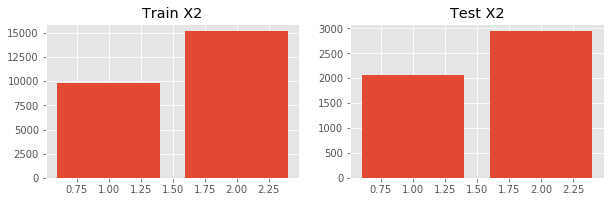

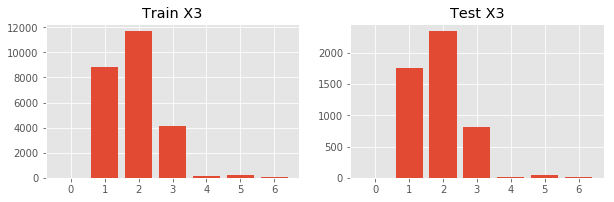

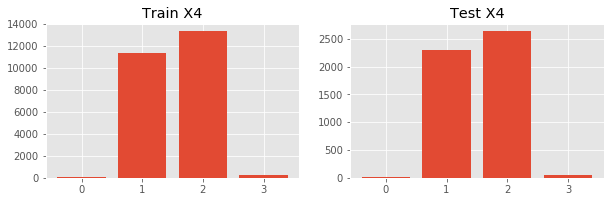

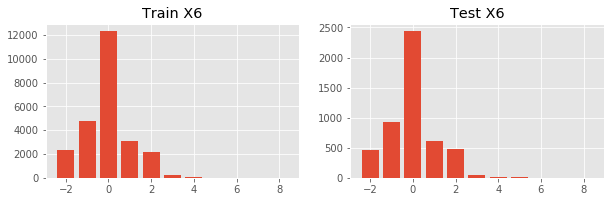

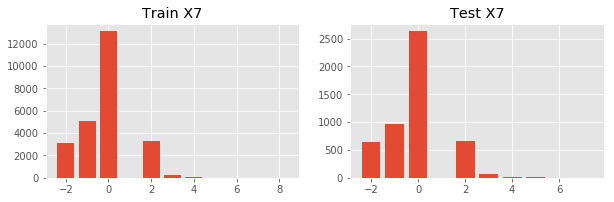

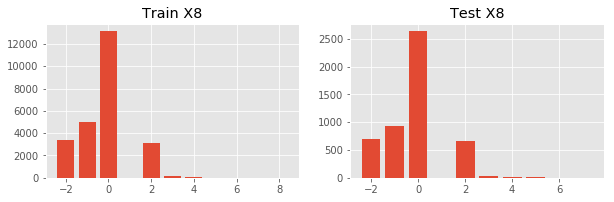

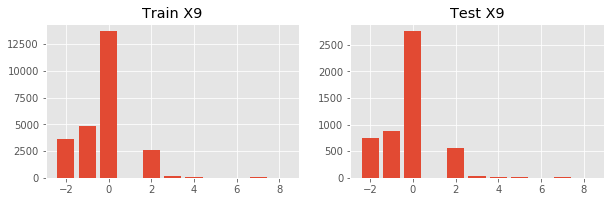

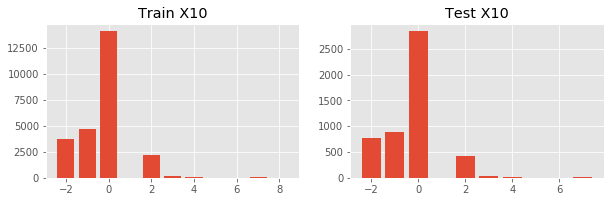

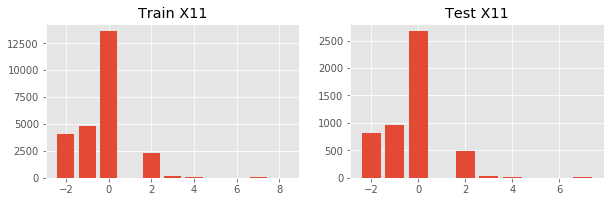

In [8]:
count = 1
for i in range(len(feat_cat)):
    fig = plt.figure(figsize=(10,30))
    plt.subplot(len(feat_cat),2,count)
    plt.bar(df_train[feat_cat[i]].value_counts().index, df_train[feat_cat[i]].value_counts().values)
    plt.title("Train "+feat_cat[i])
    
    plt.subplot(len(feat_cat),2,count+1)
    plt.bar(df_test[feat_cat[i]].value_counts().index, df_test[feat_cat[i]].value_counts().values)
    plt.title("Test "+feat_cat[i])
    count+=2

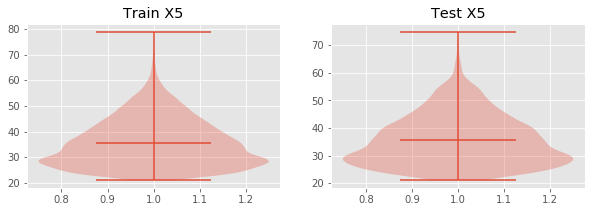

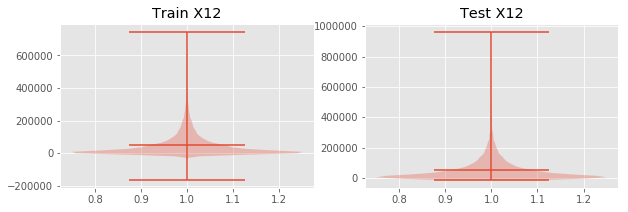

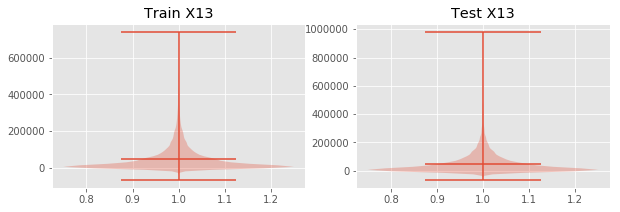

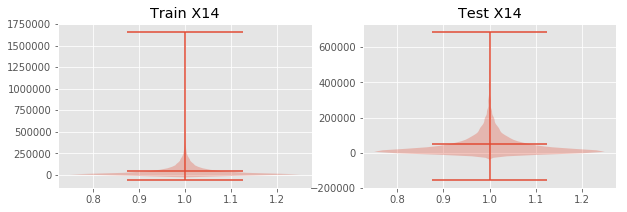

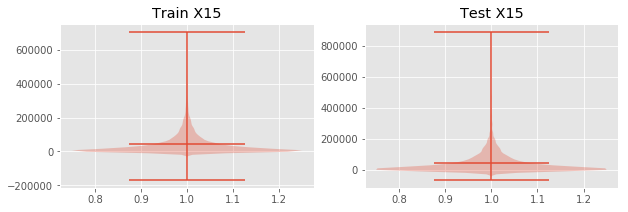

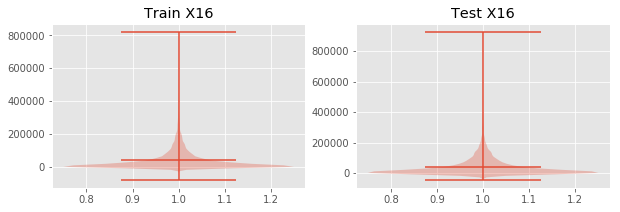

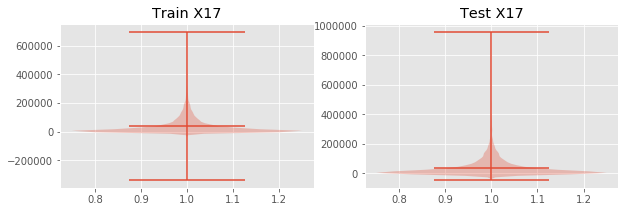

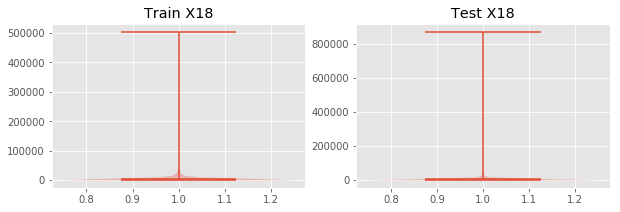

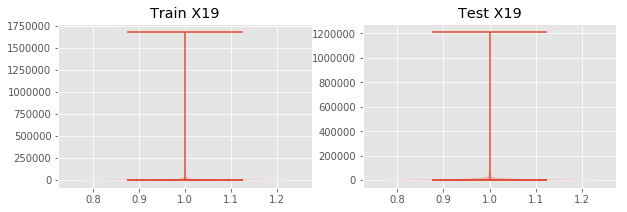

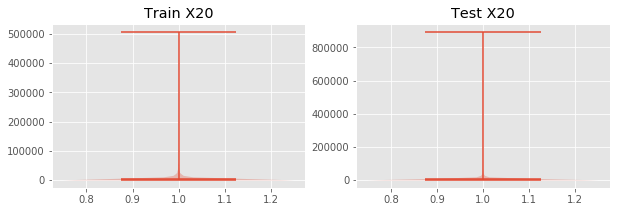

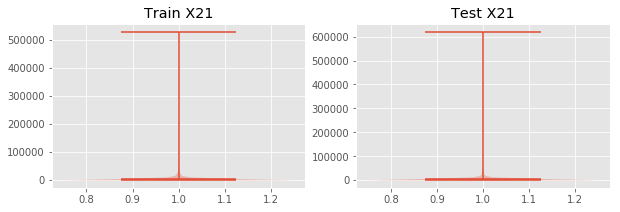

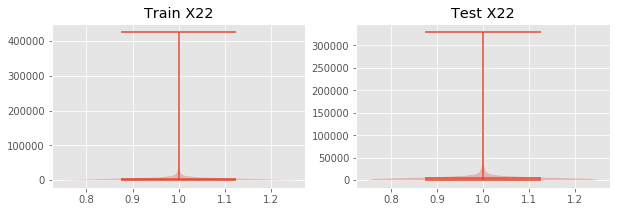

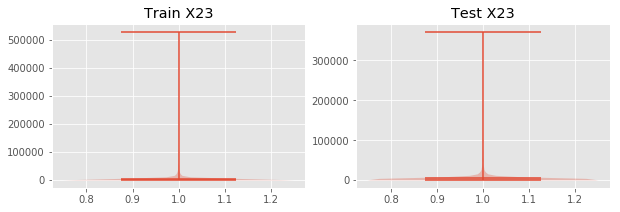

In [9]:
count = 1
for i in range(1,len(feat_num)):
    fig = plt.figure(figsize=(10,50))
    plt.subplot(len(feat_num),2,count)
    plt.violinplot(df_train[feat_num[i]], showmeans=True)
    plt.title("Train "+feat_num[i])
    
    plt.subplot(len(feat_num),2,count+1)
    plt.violinplot(df_test[feat_num[i]], showmeans=True)
    plt.title("Test "+feat_num[i])
    count+=2

** 3.2 Linear relationships between features of training data **

From the correlation heat map, features (x12-x17) as amount of bill satement from April 2015 to September 2015 are highly correlated. Good feature subsets should contain features highly correlated with the classification, yet uncorrelated to each other. Multicollinearity makes some variables statistically insignificant when they should be significant. Without multicollinearity (and thus, with lower standard errors), those coefficients might be significant. Low correlation means there's no linear relationship, it doesn't mean there is no relationship.

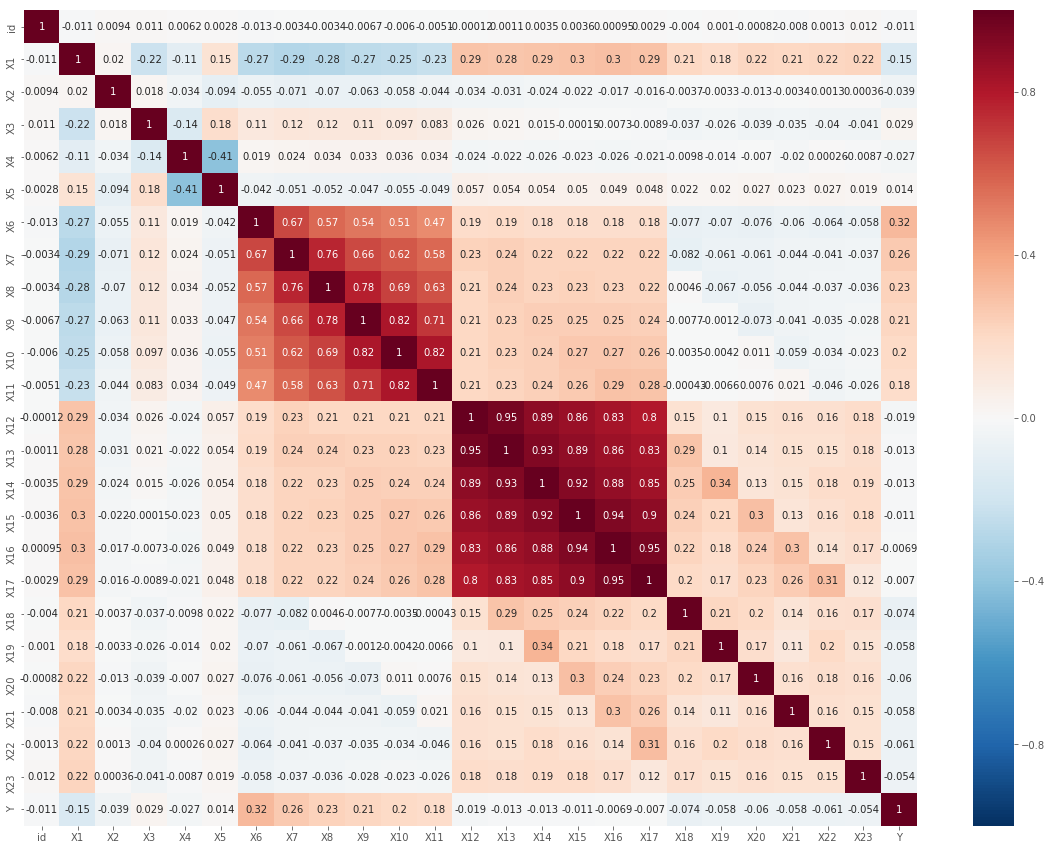

In [10]:
correlation = df_train.corr()
plt.figure(figsize=(20,15))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

**3.3 Label pattern**

Label imbalance is observed from below. We need to deal with it. 

<function matplotlib.pyplot.show>

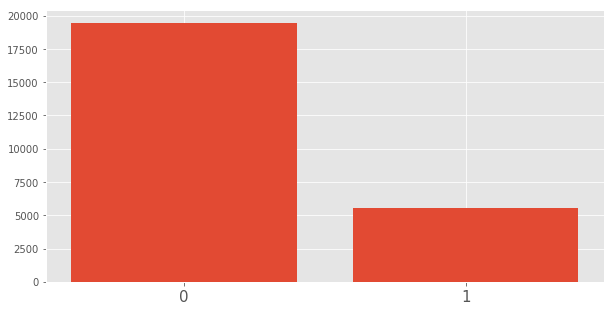

In [11]:
fig = plt.figure(figsize=(10,5))
plt.bar(df_train['Y'].value_counts().index, df_train['Y'].value_counts().values)
plt.xticks(df_train['Y'].value_counts().index, fontsize=15)
plt.show

In [12]:
df_train['Y'].value_counts()/df_train.shape[0]

0    0.77808
1    0.22192
Name: Y, dtype: float64

### 4. Data preparation 

** 4.1 One Hot Encoding for categorical features**

Among the categorical features, X2 (gender) and X4 (marital status) has no ordinal relationship, so that one hot encoding is needed for these two features. The other categorical features are ordinal ones. The original label encoding can be used.  

In [13]:
df_full = pd.concat([df_train, df_test], ignore_index=True)

In [14]:
df_full.shape

(30000, 25)

In the data description, X4 (Marital status) has 3 values (1 = married; 2 = single; 3 = others). But in the dataset, there are 54 samples with value 0. These values are combined to others. 

In [15]:
df_full['X4'].value_counts()

2    15964
1    13659
3      323
0       54
Name: X4, dtype: int64

In [16]:
df_full['X4'].replace(0, 3, inplace=True)
df_full['X4'].value_counts()

2    15964
1    13659
3      377
Name: X4, dtype: int64

In [17]:
from sklearn import preprocessing
ohe_vars = ['X2', 'X4'] 
OHE = preprocessing.OneHotEncoder(sparse=False)
OHE.fit(df_full[ohe_vars])
OHE_data = OHE.transform(df_full[ohe_vars])
OHE_vars = ['X2_1','X2_2','X4_1','X4_2','X4_3'] 

In [19]:
df_full = pd.concat((df_full, pd.DataFrame(OHE_data,columns=OHE_vars)), axis = 1)

In [20]:
print(df_full.head())

       X1  X10  X11     X12     X13     X14     X15     X16     X17   X18  \
0  200000    0    0  126027  129008  130376  133207  136159  138741  6500   
1  130000    0    0  133825  134495  133745  130814  130758  123468  7500   
2  350000    0    0  122017  121505  119522  119947  117328  118400  6000   
3  240000    0    0       0       0       0   12700   12500   26225     0   
4  180000   -1   -1    1832       0     832     332     416     416     0   

   ...   X7  X8  X9    Y  id  X2_1  X2_2  X4_1  X4_2  X4_3  
0  ...    0   0   0  0.0   1   0.0   1.0   1.0   0.0   0.0  
1  ...    0   0   2  0.0   2   0.0   1.0   0.0   1.0   0.0  
2  ...    0   0   0  0.0   3   0.0   1.0   0.0   1.0   0.0  
3  ...   -2  -2  -1  0.0   4   0.0   1.0   1.0   0.0   0.0  
4  ...   -1  -1  -1  0.0   5   1.0   0.0   0.0   1.0   0.0  

[5 rows x 30 columns]


** 4.2 Sknewness and scaling for numerical features **

Two preprocessings are applied on numerical features.<br>

1. Apply box-cox transformations for skewed numeric features. Numerical features are skewed when the calculated sknewness is greater than 0.25. <br>
2. Scale numeric features so they will fall in the range between -1 and 1.<br>

These preprocessings are not necessary for tree-based models, e.g. XGBoost. However, linear or linear-based models may benefit from them.

In [21]:
from scipy.stats import skew, boxcox
skewed_cols = df_full[feat_num].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

X5      0.732209
X1      0.992817
X12     2.663728
X13     2.705086
X15     2.821824
X17     2.846502
X16     2.876236
X14     3.087676
X23    10.640195
X22    11.126861
X21    12.904340
X18    14.667631
X20    17.215775
X19    30.452295
dtype: float64


The sknewness is calculated as above. Due to exisiting sknewd features, box-cox transformations are applied to solve the sknewness. The skeness is imporved after the box-cox transformation. 

In [22]:
skewed_cols = skewed_cols[abs(skewed_cols) > 0.25].index.values
for skewed_col in skewed_cols:
    df_full[skewed_col], lam = boxcox(df_full[skewed_col] + abs(df_full[skewed_col].min()) + 1)

In [23]:
skewed_cols = df_full[feat_num].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

X13   -0.230925
X22   -0.178914
X23   -0.175010
X21   -0.165682
X20   -0.151908
X18   -0.133105
X16   -0.127054
X19   -0.112966
X1    -0.052400
X5     0.058815
X12    0.255959
X14    0.259345
X15    0.362404
X17    0.885103
dtype: float64


The scales among features are different. A standadard scaling is applied to tansform the numerical features to the same range. The violin plot after box-cox and standard scaling showed that the data are processed as expected, comparing with violin plot before these transformations. 

In [24]:
SSL = preprocessing.StandardScaler()
for con_col in feat_num:
     df_full[con_col] = SSL.fit_transform(df_full[con_col].values.reshape(-1,1))

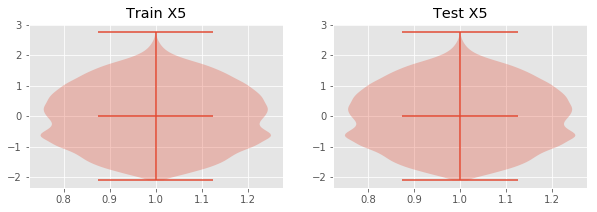

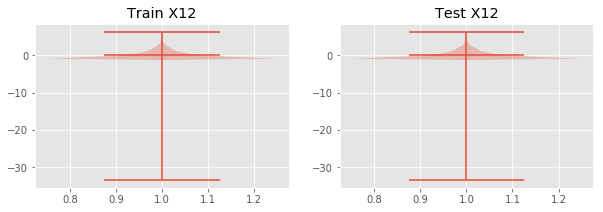

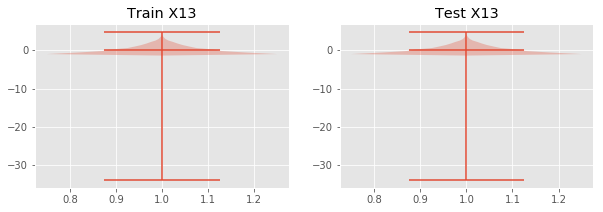

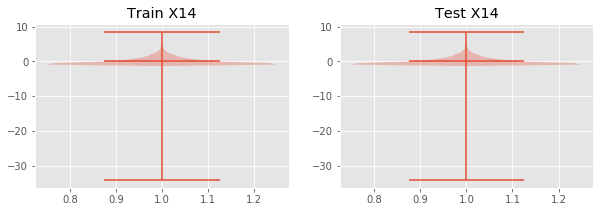

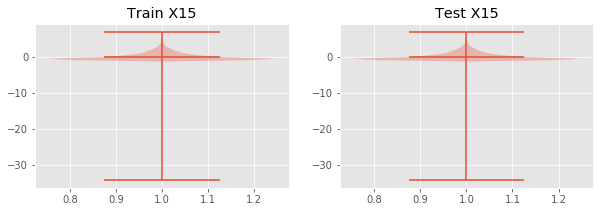

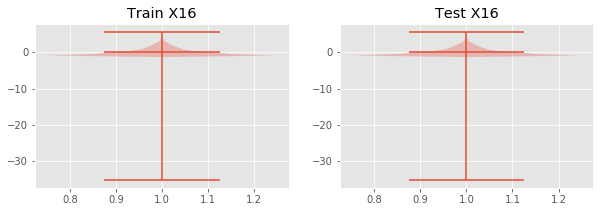

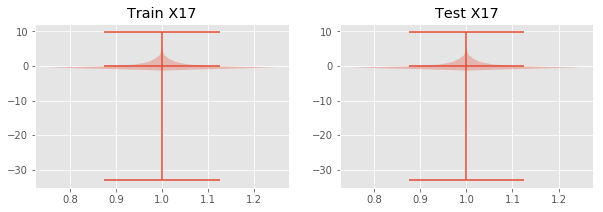

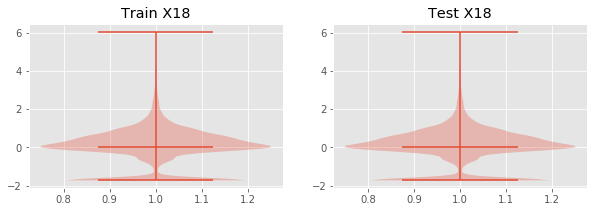

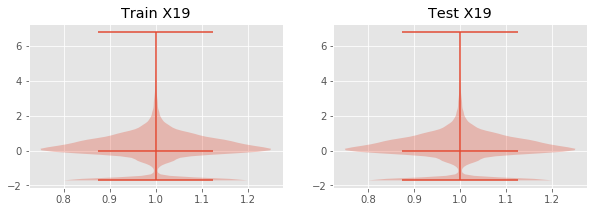

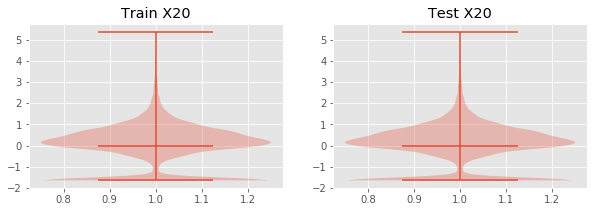

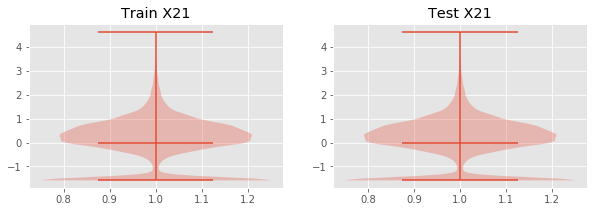

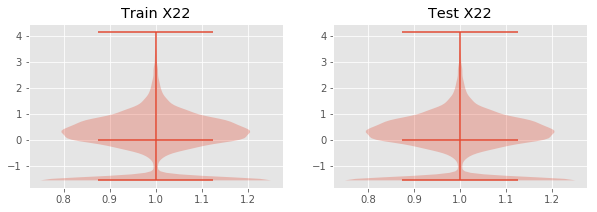

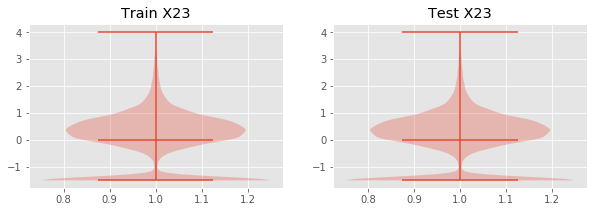

In [25]:
count = 1
for i in range(1,len(feat_num)):
    fig = plt.figure(figsize=(10,50))
    plt.subplot(len(feat_num),2,count)
    plt.violinplot(df_full[feat_num[i]], showmeans=True)
    plt.title("Train "+feat_num[i])
    
    plt.subplot(len(feat_num),2,count+1)
    plt.violinplot(df_full[feat_num[i]], showmeans=True)
    plt.title("Test "+feat_num[i])
    count+=2

** 4.3 Data splitting **

Train dataset is splitted two parts for training and testing in model building with ratio 0.8:0.2.

In [26]:
df_train = df_full.drop(['id','X2','X4'], axis=1)[:df_train.shape[0]]

In [56]:
df_test = df_full.drop(['X2','X4'], axis=1)[df_train.shape[0]:]

In [27]:
from sklearn.model_selection import train_test_split
Y = df_train['Y']
X = df_train.drop(['Y'], axis= 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

### 5. Models

** 5.1 Logistic Regression **

In [28]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight = {0:1, 1:3})
LR = LR.fit(x_train, y_train)
LR_pred = LR.predict(x_test)
print (metrics.classification_report(y_test, LR_pred))
print('Accuracy score:', accuracy_score(y_test, LR_pred))

             precision    recall  f1-score   support

        0.0       0.87      0.80      0.84      3923
        1.0       0.45      0.57      0.50      1077

avg / total       0.78      0.75      0.76      5000

Accuracy score: 0.7544


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
def search_model(x_train, y_train, est, param_grid, n_jobs, cv):
    model = GridSearchCV(estimator = est,
                         param_grid = param_grid,
                         scoring = 'f1_weighted',
                         verbose = 10,
                         n_jobs = n_jobs,
                         iid = True,
                         cv = cv)
    # Fit Grid Search Model 
    model.fit(x_train, y_train)
    return model

In [30]:
param_grid = {'penalty': ['l1', 'l2'],
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 500],
             'class_weight': [{0:1, 1:3}]}

LR = search_model(X.values,
                 Y.values,
                 LogisticRegression(),
                 param_grid,
                 -1, 
                 5)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l1 ..................
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l1 ..................
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l1 ..................
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l1 ..................
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7668787528172964, total=   0.1s
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7727846645364695, total=   0.1s
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l1 ..................
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7685484503782395, total=   0.1s
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l2 ..................
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l2 ..................
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7734223795822304, total=   0.2s
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l2 ..............

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1999s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7663417232620462, total=   0.2s
[CV] C=0.01, class_weight={0: 1, 1: 3}, penalty=l1 ...................
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7715937884204312, total=   0.1s
[CV] C=0.01, class_weight={0: 1, 1: 3}, penalty=l1 ...................
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7688585638573427, total=   0.2s
[CV] C=0.01, class_weight={0: 1, 1: 3}, penalty=l1 ...................
[CV]  C=0.001, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7681367143670645, total=   0.2s
[CV] C=0.001, class_weight={0: 1, 1: 3}, penalty=l2 ..................
[CV]  C=0.01, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7704314158424183, total=   0.2s
[CV]  C=0.01, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7646350045580075, total=   0.2s
[CV] C=0.01, class_weight={0: 1, 1: 3}, penalty=l2 ...................
[CV] C=0.01, class_weight={0: 1, 1: 3}, penalty=l1 ...................
[CV]  C=0.01

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s


[CV]  C=0.01, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7664675304597638, total=   0.2s
[CV] C=0.01, class_weight={0: 1, 1: 3}, penalty=l2 ...................
[CV]  C=0.1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7707082146235977, total=   0.3s
[CV] C=0.1, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV]  C=0.01, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7703208974185701, total=   0.2s
[CV]  C=0.01, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7652923055721471, total=   0.2s
[CV]  C=0.1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7653235522298127, total=   0.4s
[CV] C=0.1, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV] C=0.1, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV] C=0.1, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=0.1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7659852140267601, total=   0.2s
[CV] C=0.1, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=0.1, class_

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s


[CV]  C=0.1, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7657906428335002, total=   0.2s
[CV] C=1, class_weight={0: 1, 1: 3}, penalty=l1 ......................
[CV]  C=0.1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7651789587886856, total=   0.9s
[CV] C=0.1, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=0.1, class_weight={0: 1, 1: 3}, penalty=l2, score=0.765044290576722, total=   0.2s
[CV] C=1, class_weight={0: 1, 1: 3}, penalty=l2 ......................
[CV]  C=1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7707082146235977, total=   0.8s
[CV] C=1, class_weight={0: 1, 1: 3}, penalty=l1 ......................
[CV]  C=1, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7678475068010349, total=   0.3s
[CV] C=1, class_weight={0: 1, 1: 3}, penalty=l2 ......................
[CV]  C=1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.765624526101921, total=   0.8s
[CV]  C=1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7646594327398288, total=   1.2s
[CV] C=1, c

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.2s


[CV]  C=10, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7644934131347096, total=   0.2s
[CV] C=10, class_weight={0: 1, 1: 3}, penalty=l2 .....................
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV]  C=1, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7679422214397408, total=   1.8s
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV]  C=10, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7662512393398754, total=   0.2s
[CV] C=10, class_weight={0: 1, 1: 3}, penalty=l2 .....................
[CV]  C=10, class_weight={0: 1, 1: 3}, penalty=l2, score=0.770763394427918, total=   0.3s
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l1 ....................


[Parallel(n_jobs=-1)]: Batch computation too slow (2.2877s.) Setting batch_size=1.


[CV]  C=10, class_weight={0: 1, 1: 3}, penalty=l2, score=0.765624526101921, total=   0.2s
[CV]  C=100, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7644934131347096, total=   0.4s
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV]  C=100, class_weight={0: 1, 1: 3}, penalty=l1, score=0.770763394427918, total=   0.3s
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV]  C=100, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7678475068010349, total=   0.2s
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=100, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7678475068010349, total=   0.3s
[CV]  C=100, class_weight={0: 1, 1: 3}, penalty=l1, score=0.765624526101921, total=   0.4s
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV] C=100, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=100, class_weight=

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.5s


[CV]  C=100, class_weight={0: 1, 1: 3}, penalty=l2, score=0.765624526101921, total=   0.2s
[CV] C=500, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV]  C=500, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7644934131347096, total=   0.4s
[CV]  C=500, class_weight={0: 1, 1: 3}, penalty=l1, score=0.7678475068010349, total=   0.4s
[CV] C=500, class_weight={0: 1, 1: 3}, penalty=l1 ....................
[CV] C=500, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=500, class_weight={0: 1, 1: 3}, penalty=l1, score=0.770763394427918, total=   0.4s
[CV] C=500, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=500, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7644934131347096, total=   0.2s
[CV]  C=500, class_weight={0: 1, 1: 3}, penalty=l2, score=0.7678475068010349, total=   0.2s
[CV] C=500, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV] C=500, class_weight={0: 1, 1: 3}, penalty=l2 ....................
[CV]  C=500, class_weigh

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    6.3s finished


In [31]:
print("Best score: %0.3f" % LR.best_score_)
print("Best parameters set:", LR.best_params_)
print("Scores:", LR.grid_scores_)

Best score: 0.769
Best parameters set: {'C': 0.001, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}
Scores: [mean: 0.76948, std: 0.00310, params: {'C': 0.001, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}, mean: 0.76827, std: 0.00193, params: {'C': 0.001, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2'}, mean: 0.76748, std: 0.00208, params: {'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}, mean: 0.76706, std: 0.00185, params: {'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2'}, mean: 0.76710, std: 0.00213, params: {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}, mean: 0.76714, std: 0.00212, params: {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2'}, mean: 0.76707, std: 0.00211, params: {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}, mean: 0.76700, std: 0.00217, params: {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2'}, mean: 0.76700, std: 0.00217, params: {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}, mean: 0.76700, std: 0.00217

/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [32]:
clf1 = LogisticRegression(C=0.001, penalty='l1', class_weight = {0:1, 1:3})

** 5.2 Random Forest**

Build a baseline model.

In [33]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(class_weight = {0:1, 1:3})
RF = RF.fit(x_train, y_train)
RF_pred = RF.predict(x_test)
print (metrics.classification_report(y_test, RF_pred))
print('Accuracy score:', accuracy_score(y_test, RF_pred))

             precision    recall  f1-score   support

        0.0       0.83      0.94      0.88      3923
        1.0       0.59      0.29      0.39      1077

avg / total       0.78      0.80      0.78      5000

Accuracy score: 0.8036


Basic parameter tuning: Grid searching

In [34]:
param_grid = {'n_estimators': [100,300,500],
             'criterion': ['gini', 'entropy'],
             'class_weight': [{0:1, 1:3}],
             'min_samples_leaf': [1,2,3],
             'max_depth': [5,8,10]}

RF = search_model(X.values,
                 Y.values,
                 RandomForestClassifier(),
                 param_grid,
                 -1, # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
                 5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100 
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100 
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100 
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100, score=0.7929062456530408, total=   3.0s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100, score=0.7982807310860408, total=   3.1s
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=100, score=0.7891902731898938, total=   3.0s
[CV] class_weight={0: 1

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.4s


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=300, score=0.793140213486695, total=   8.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=300, score=0.7904214436794393, total=   8.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=300, score=0.796454000121223, total=   8.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=300, score=0.7973921073763447, total=   9.1s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gin

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.0s


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500, score=0.7970569629376125, total=  14.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500, score=0.7928414317136573, total=  14.5s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500, score=0.7907249722047157, total=  14.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100, score=0.7912425726753185, total=   3.2s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.4s


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=500, score=0.7977422658206568, total=  14.7s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7917420179645113, total=   8.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7950926986270712, total=   8.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7901286292910407, total=   8.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   52.2s


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7961090593908186, total=   8.2s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500, score=0.7939734102704357, total=  13.7s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500, score=0.7966020622877615, total=  13.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=100, score=0.7897097038263822, total=   2.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=100, score=0.7990417258681107, total=   2.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=500, score=0.7974055789756296, total=  13.1s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=300, score=0.7932074435454125, total=   7.8s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=300, score=0.7958113997504935, total=   7.8s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=500, score=0.7900892304067233, total=  13.2s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=100, score=0.7942019647136245, total=   3.9s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=5, min_samples_leaf=3, n_estimators=500, score=0.7964901901087101, total=  13.3s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=100, score=0.7934411115815653, total=   3.8s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.0min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=300, score=0.8015356420651563, total=  11.1s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=300, score=0.7914270986403396, total=  11.0s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=500, score=0.7943339678890364, total=  18.3s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=500, score=0.7946729490336027, total=  18.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=1, n_estimators=500, score=0.7902363875003225, total=  20.9s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=300, score=0.7924047159379266, total=  14.0s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=300, score=0.7952341495124101, total=  14.1s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=300, score=0.7901662080109977, total=  14.2s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.3min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=100, score=0.8023402683612467, total=   4.1s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=100, score=0.7894471160202127, total=   3.9s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=2, n_estimators=500, score=0.7923248221307331, total=  19.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=300, score=0.7948057973260142, total=  11.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=g

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.0min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=100, score=0.791855111576906, total=   4.5s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=8, min_samples_leaf=3, n_estimators=500, score=0.7999599919983997, total=  19.0s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=100, score=0.7999775766986553, total=   4.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=100, score=0.7922182953075232, total=   4.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, crite

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.9min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=100, score=0.7912404418867244, total=   4.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=1, n_estimators=500, score=0.8033183806930649, total=  22.3s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=100, score=0.8040735775276645, total=   4.4s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=100, score=0.7982695680225119, total=   4.3s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, cri

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.8min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=500, score=0.802953697811615, total=  23.6s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=100, score=0.7921238228438229, total=   4.8s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=100, score=0.8022246459075437, total=   4.7s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=100, score=0.795193607790129, total=   4.7s
[CV] class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, crite

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  6.7min


[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=500, score=0.8030655003113704, total=  21.9s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=100, score=0.798396835820782, total=   3.1s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=300, score=0.7923075003624207, total=   9.2s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=500, score=0.7963287063372995, total=  21.7s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=300 
[CV]  class_weight={0: 1,

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.4min


[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=1, n_estimators=500, score=0.7986020027218363, total=  16.9s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7931078568157446, total=  10.3s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7955468583379862, total=  10.4s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=300, score=0.7893959737336906, total=  10.3s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=2, n_estimators=500 
[CV]  class_weight={

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8.3min


[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=300, score=0.7977634244740616, total=  10.2s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=300, score=0.7954580425954026, total=  10.1s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=500, score=0.7972133761381016, total=  16.1s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=5, min_samples_leaf=3, n_estimators=500, score=0.7939412194364077, total=  16.3s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=1, n_estimators=100 
[CV]  class_weight={

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.5min


[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=1, n_estimators=500, score=0.7919003289571293, total=  24.2s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100, score=0.7945659101730147, total=   4.5s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100, score=0.7953376951764507, total=   4.6s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100, score=0.7882401045543254, total=   4.6s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 10.6min


[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=2, n_estimators=500, score=0.7924917958951256, total=  22.5s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=300, score=0.7920713933249647, total=  13.5s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=300, score=0.7955773489931071, total=  13.3s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=300, score=0.7924330153697147, total=  13.4s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=8, min_samples_leaf=3, n_estimators=500 
[CV]  class_weight={

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 11.9min


[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=1, n_estimators=300, score=0.7949935569369653, total=  16.3s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=1, n_estimators=500, score=0.7937463844402839, total=  27.3s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=1, n_estimators=500 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=1, n_estimators=500, score=0.8006338282956007, total=  27.4s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=2, n_estimators=100 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=2, n_estimators=100, score=0.7925120095886019, total=   5.5s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=2, n_estimators=100 
[CV]  class_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 13.6min


[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=100, score=0.8016190254018364, total=   5.5s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=100, score=0.7940251128577916, total=   5.4s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=2, n_estimators=500, score=0.7950874738557231, total=  27.8s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=300, score=0.7932074435454125, total=  16.6s
[CV] class_weight={0: 1, 1: 3}, criterion=entropy, max_depth=10, min_samples_leaf=3, n_estimators=300 
[CV]  class_

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 14.8min finished


In [35]:
print("Best score: %0.3f" % RF.best_score_)
print("Best parameters set:", RF.best_params_)
print("Scores:", RF.grid_scores_) 

Best score: 0.797
Best parameters set: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 300}
Scores: [mean: 0.79428, std: 0.00308, params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}, mean: 0.79469, std: 0.00256, params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 300}, mean: 0.79487, std: 0.00267, params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 500}, mean: 0.79331, std: 0.00266, params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}, mean: 0.79397, std: 0.00258, params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 300}, mean: 0.79484, std: 0.00252, params: {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 

/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Random Forest classification model with the best parameters from grid searching.

In [38]:
clf2 = RandomForestClassifier(n_estimators=300, criterion='gini',class_weight={0:1, 1:3}, min_samples_leaf=3, max_depth=10)

** 5.3 Other models **

** KNN **

In [45]:
from sklearn.neighbors import KNeighborsClassifier
clf3 = KNeighborsClassifier(n_neighbors=15, weights='distance')
clf3.fit(x_train, y_train)
clf3_pred = clf3.predict(x_test)
print('Accuracy score:', accuracy_score(y_test, clf3_pred))

Accuracy score: 0.8054


**SVM**

In [51]:
from sklearn.svm import SVC
clf4 = SVC(class_weight = {0:1, 1:3})
clf4.fit(x_train, y_train)
clf4_pred = clf4.predict(x_test)
print(classification_report(y_test, clf4_pred))
print('Accuracy score:', accuracy_score(y_test, clf4_pred))

             precision    recall  f1-score   support

        0.0       0.87      0.85      0.86      3923
        1.0       0.50      0.55      0.53      1077

avg / total       0.79      0.78      0.79      5000

Accuracy score: 0.7844


### 6. Model ensemble

In [73]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('Logistic', clf1), ('Random_Forest',clf1), ('KNN', clf3), ('SVM', clf4)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Logistic','Random_Forest', 'KNN','SVM', 'Ensemble']):
    scores = cross_val_score(clf, X, Y, cv=3, scoring='f1_weighted')
    print ("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.77 (+/- 0.00) [Logistic]
Accuracy: 0.80 (+/- 0.00) [Random_Forest]
Accuracy: 0.78 (+/- 0.00) [KNN]
Accuracy: 0.79 (+/- 0.00) [SVM]
Accuracy: 0.80 (+/- 0.00) [Ensemble]


### 7. Final submission

In [75]:
eclf.fit(X, Y)
y = pd.DataFrame(eclf.predict(df_test.drop(['id','Y'],axis=1)), columns=['y'])

In [107]:
df_id = pd.DataFrame(df_test['id']).reset_index().drop(['index'], axis=1)
predict_data = pd.concat([df_id, y], axis=1)
predict_data.to_csv('Submmission.csv', index=False)

In [109]:
predict_data.y.value_counts()

0.0    3873
1.0    1127
Name: y, dtype: int64